In [ ]:
import sys
from pathlib import Path
import datetime as dt
import numpy as np 
import pandas as pd
import json
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score,  train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

ML_LOC = PROJPATH / "data/ML_2024_redux"

#### Let's start with Nenana (or another location)

In [ ]:
location = "Tanana River at Nenana"
df = pd.read_csv(ML_LOC / f"DF/DF_{location.replace(' ', '_')}", index_col=0)
df.rename(columns={'t2m': 't2m_M', 'ssr': 'ssr_M', 'sd': 'sd_M'}, inplace=True)
Xy = df.loc[1980:2023, :].dropna()
# Xy.reset_index(inplace=True, names='year')
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
X_2024 = df.iloc[-1, :-1]
# X_2024 = df.reset_index(names='year').iloc[-1, :-1]

#### Feature selection

In [ ]:
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
X.columns

Index(['AO_DJ', 'AO_FM', 'EP-NP_DJ', 'EP-NP_FM', 'PNA_DJ', 'PNA_FM',
       'Nino1+2_DJ', 'Nino1+2_FM', 'Nino4_DJ', 'Nino4_FM', 'NPI_anom_FM',
       'NAO_DJ', 'NAO_FM', 'EA_DJ', 'EA_FM', 'WP_DJ', 'WP_FM', 'EA-WR_DJ',
       'EA-WR_FM', 'SCA_DJ', 'SCA_FM', 'POL_DJ', 'POL_FM',
       'seaice_ber_anom_DJ', 'seaice_ber_anom_FM', 'seaice_chuk_anom_DJ',
       'seaice_chuk_anom_FM', 'NenanaIceThick', 't2m_M', 'ssr_M', 'sd_M'],
      dtype='object')

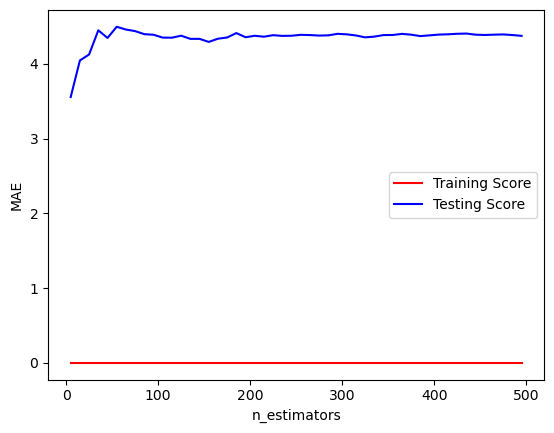

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

numtreeslist = np.arange(5, 500, 10)
train_results = []
test_results = []
for ntrees in numtreeslist:
    clf = ExtraTreesRegressor(n_estimators=ntrees, random_state=41)
    clf = clf.fit(X_train, y_train)
    train_results.append(mean_absolute_error(y_train, clf.predict(X_train)))
    test_results.append(mean_absolute_error(y_test, clf.predict(X_test)))

line1, = plt.plot(numtreeslist, train_results, color="r", label="Training Score")
line2, = plt.plot(numtreeslist, test_results, color="b", label="Testing Score")

plt.legend()
plt.ylabel('MAE')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
clf = ExtraTreesRegressor(n_estimators=100, random_state=42)
clf = clf.fit(X, y)
clf.feature_importances_
selector = SelectFromModel(clf, prefit=True, max_features=6)
X_new = X[X.columns[selector.get_support()]]
X_new

,AO_DJ,AO_FM,Nino4_DJ,Nino4_FM,EA-WR_DJ,POL_DJ
1980,-0.385,-1.183,0.330,0.275,-0.430,-0.675
1981,-0.087,-0.989,-0.080,-0.170,-0.755,0.990
1982,-1.050,1.024,-0.060,-0.055,0.160,-0.035
1983,1.163,-1.187,0.450,0.280,0.165,-1.035
1984,0.545,-1.345,-0.830,-0.785,-1.000,-0.150
1985,-1.180,-0.444,-0.795,-0.860,-0.195,-1.405
1986,-1.258,-0.486,-0.245,-0.195,0.155,-0.020
1987,-0.544,-1.610,0.310,0.485,1.020,-0.545
1988,-0.135,-0.632,0.705,0.295,-0.170,0.730
1989,2.393,2.405,-1.745,-1.345,0.605,0.165


In [ ]:
%timeit
clf = ExtraTreesRegressor(n_estimators=100, random_state=40)
sfs_forward = SequentialFeatureSelector(
    clf, n_features_to_select=4, direction="forward"
).fit(X, y)

In [ ]:
%timeit
clf = ExtraTreesRegressor(n_estimators=100, random_state=40)
sfs_backward = SequentialFeatureSelector(
    clf, n_features_to_select=4, direction="backward"
).fit(X, y)

In [ ]:
X[sfs_forward.get_feature_names_out()].corrwith(y)

AO_FM      -0.287858
Nino4_FM   -0.371890
SCA_FM      0.213323
sd_M        0.091946
dtype: float64

In [ ]:
X_forVIF = add_constant(X)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_forVIF.columns
vif_data['VIF'] = [variance_inflation_factor(X_forVIF.values, i) for i in range(X_forVIF.shape[1])]

In [ ]:
X[sfs_backward.get_feature_names_out()].corrwith(y)

NameError: name 'sfs_backward' is not defined

In [ ]:
X.corr()

,AO_DJ,AO_FM,EP-NP_DJ,EP-NP_FM,PNA_DJ,PNA_FM,Nino1+2_DJ,Nino1+2_FM,Nino4_DJ,Nino4_FM,...,POL_DJ,POL_FM,seaice_ber_anom_DJ,seaice_ber_anom_FM,seaice_chuk_anom_DJ,seaice_chuk_anom_FM,NenanaIceThick,t2m_M,ssr_M,sd_M
AO_DJ,1.000000,0.308948,-0.301098,0.120616,-0.274026,0.099524,0.088447,0.101323,0.021234,-0.000987,...,0.069038,0.198889,0.224663,0.085865,0.030972,-0.061552,-0.135866,-0.046184,-0.027422,0.293602
AO_FM,0.308948,1.000000,0.011932,0.178006,-0.292400,-0.559976,-0.122913,0.054169,-0.097485,0.034671,...,0.184878,0.233646,-0.031140,-0.197275,-0.166705,-0.099062,-0.171638,-0.062884,-0.117108,0.218954
EP-NP_DJ,-0.301098,0.011932,1.000000,0.291550,0.061039,-0.071129,0.125887,-0.147047,0.397484,0.414950,...,0.197679,0.140845,-0.325492,-0.354677,-0.113750,-0.214524,-0.137269,0.279170,-0.216853,0.024290
EP-NP_FM,0.120616,0.178006,0.291550,1.000000,0.034653,-0.095826,0.170136,0.128617,0.269068,0.329081,...,0.291259,0.562016,0.036364,-0.451109,0.135372,-0.417595,-0.251383,0.255376,0.197496,-0.043723
PNA_DJ,-0.274026,-0.292400,0.061039,0.034653,1.000000,0.340372,0.452050,0.276028,0.375747,0.358374,...,0.010101,-0.043678,-0.221257,-0.156660,-0.055882,0.041698,0.128597,-0.003067,0.225656,-0.512452
PNA_FM,0.099524,-0.559976,-0.071129,-0.095826,0.340372,1.000000,0.482464,0.343446,0.362157,0.247652,...,-0.009595,-0.058606,0.205515,0.381484,0.254262,0.309581,0.020100,0.203851,0.232609,-0.116669
Nino1+2_DJ,0.088447,-0.122913,0.125887,0.170136,0.452050,0.482464,1.000000,0.741853,0.559847,0.532962,...,-0.211406,0.155791,0.015669,0.057817,0.053923,0.057814,-0.048197,0.097449,0.271843,-0.258912
Nino1+2_FM,0.101323,0.054169,-0.147047,0.128617,0.276028,0.343446,0.741853,1.000000,0.286132,0.317899,...,-0.175640,0.161073,0.065963,0.155810,-0.045286,0.243622,-0.028943,-0.044495,0.361219,-0.196054
Nino4_DJ,0.021234,-0.097485,0.397484,0.269068,0.375747,0.362157,0.559847,0.286132,1.000000,0.967649,...,0.163310,0.104998,-0.116439,-0.020087,0.000979,0.050990,-0.150610,0.195013,-0.081753,-0.059475
Nino4_FM,-0.000987,0.034671,0.414950,0.329081,0.358374,0.247652,0.532962,0.317899,0.967649,1.000000,...,0.196886,0.148336,-0.194356,-0.085116,-0.039765,0.018074,-0.182781,0.179506,-0.039406,-0.028911


In [ ]:
X_new.corrwith(y)

AO_DJ            -0.269059
Nino4_DJ         -0.354766
Nino4_FM         -0.371890
NAO_FM           -0.339745
EA-WR_DJ          0.119953
NenanaIceThick    0.371098
dtype: float64

### Let's try a multiple linear regression to assess collinearity

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

<Axes: >

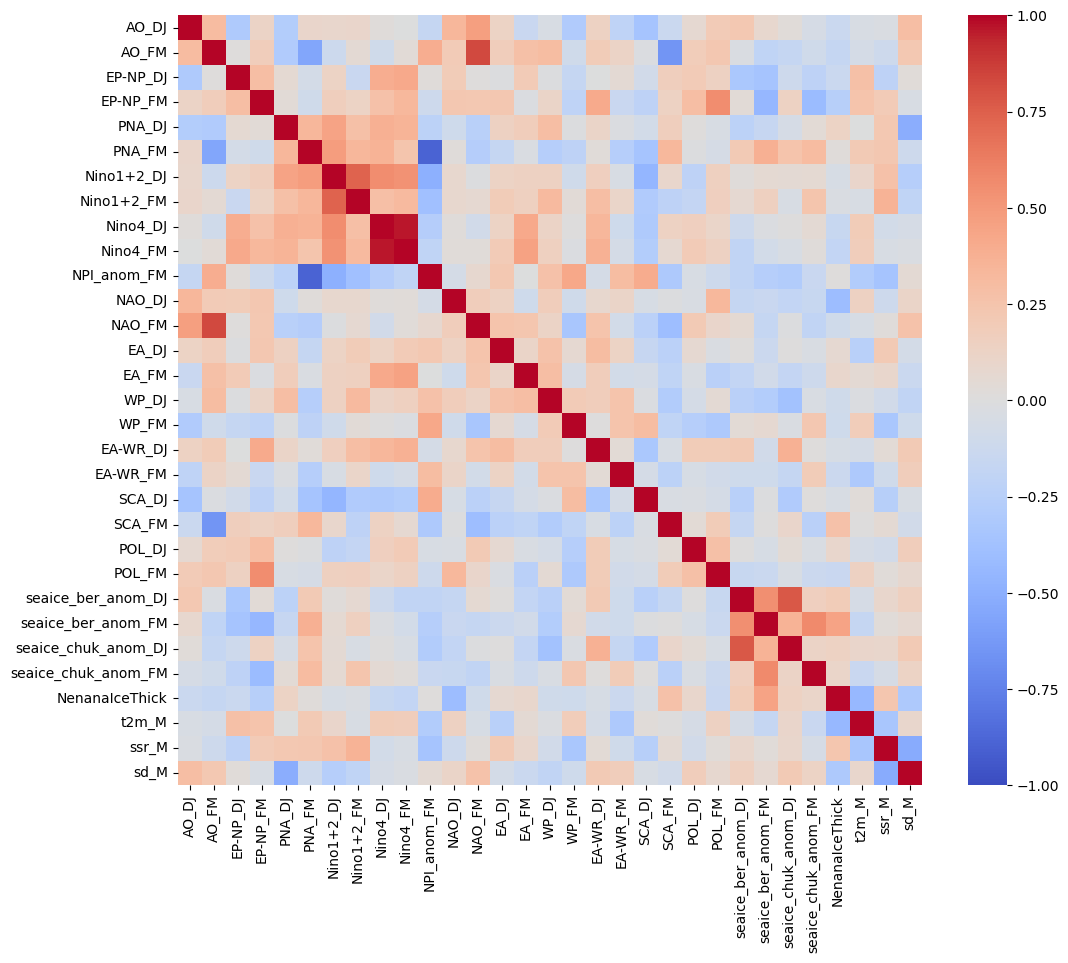

In [ ]:
figure = plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(),cmap='coolwarm', vmin=-1, vmax=1)

In [ ]:
X_forVIF = add_constant(X)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_forVIF.columns
vif_data['VIF'] = [variance_inflation_factor(X_forVIF.values, i) for i in range(X_forVIF.shape[1])]

In [ ]:
X.corrwith(y).sort_values(key=abs, ascending=False)

Nino1+2_DJ            -0.415345
Nino4_FM              -0.371890
NenanaIceThick         0.371098
Nino4_DJ              -0.354766
NAO_FM                -0.339745
AO_FM                 -0.287858
AO_DJ                 -0.269059
EA_FM                 -0.248810
Nino1+2_FM            -0.228607
t2m_M                 -0.220047
SCA_FM                 0.213323
NAO_DJ                -0.192071
NPI_anom_FM            0.187477
SCA_DJ                 0.151894
seaice_ber_anom_FM     0.144563
PNA_DJ                -0.143339
PNA_FM                -0.139982
EA-WR_DJ               0.119953
EA-WR_FM               0.095792
EP-NP_DJ              -0.093457
sd_M                   0.091946
EP-NP_FM              -0.082457
WP_DJ                 -0.074875
seaice_chuk_anom_FM    0.068682
EA_DJ                 -0.058790
WP_FM                 -0.054003
ssr_M                 -0.039593
POL_DJ                -0.032490
seaice_ber_anom_DJ     0.025202
seaice_chuk_anom_DJ    0.023439
POL_FM                 0.008187
dtype: f

In [ ]:
predictorlist = vif_data.sort_values('VIF', ascending=False)['Feature'].to_list()
predictorlist.remove('const')
predictorlist[1:]

['Nino4_DJ',
 'Nino4_FM',
 'NAO_FM',
 'NPI_anom_FM',
 'PNA_FM',
 'SCA_FM',
 'seaice_ber_anom_DJ',
 'POL_FM',
 'seaice_ber_anom_FM',
 'Nino1+2_DJ',
 'Nino1+2_FM',
 'EP-NP_FM',
 'seaice_chuk_anom_DJ',
 'NenanaIceThick',
 'ssr_M',
 't2m_M',
 'sd_M',
 'EP-NP_DJ',
 'EA_DJ',
 'WP_FM',
 'NAO_DJ',
 'EA_FM',
 'AO_DJ',
 'seaice_chuk_anom_FM',
 'PNA_DJ',
 'EA-WR_DJ',
 'EA-WR_FM',
 'SCA_DJ',
 'WP_DJ',
 'POL_DJ']

In [ ]:
X_forVIF

,const,AO_DJ,EP-NP_DJ,EP-NP_FM,PNA_DJ,PNA_FM,Nino1+2_DJ,Nino1+2_FM,Nino4_DJ,Nino4_FM,...,POL_DJ,POL_FM,seaice_ber_anom_DJ,seaice_ber_anom_FM,seaice_chuk_anom_DJ,seaice_chuk_anom_FM,NenanaIceThick,t2m_M,ssr_M,sd_M
1980,1.0,-0.385,0.53,0.505,-0.845,0.695,-0.165,-0.215,0.330,0.275,...,-0.675,0.235,72796.097,75710.183,21679.526,-19276.681,39.755556,11.388,26.717,0.081
1981,1.0,-0.087,1.02,0.000,0.945,0.740,-0.950,-0.860,-0.080,-0.170,...,0.990,-0.330,86952.835,26487.476,17966.648,-6019.920,39.755556,17.890,26.014,0.079
1982,1.0,-1.050,1.11,0.785,-1.085,-1.430,-0.220,-1.040,-0.060,-0.055,...,-0.035,-0.145,40701.977,-96388.226,24221.572,-31356.242,39.755556,4.622,27.545,0.113
1983,1.0,1.163,-0.31,-0.455,0.660,1.735,2.905,2.130,0.450,0.280,...,-1.035,0.030,21124.389,49359.743,15481.615,-1402.764,39.755556,3.854,27.194,0.108
1984,1.0,0.545,-0.97,-0.215,-0.005,0.905,-0.090,-0.875,-0.830,-0.785,...,-0.150,0.740,-89707.528,94515.412,-31582.156,-29958.123,39.755556,15.756,25.067,0.094
1985,1.0,-1.180,1.00,-1.540,-0.230,-1.090,-0.590,-1.135,-0.795,-0.860,...,-1.405,-0.120,-72888.154,-89663.552,18533.806,-1291.347,39.755556,10.888,25.871,0.138
1986,1.0,-1.258,0.52,0.450,0.840,0.460,-0.190,-0.415,-0.245,-0.195,...,-0.020,1.535,-65567.861,-8794.729,7294.795,2074.965,39.755556,2.691,26.654,0.078
1987,1.0,-0.544,-0.74,0.120,0.845,0.710,0.795,1.205,0.310,0.485,...,-0.545,0.205,-16733.320,5861.737,12678.787,4041.550,39.755556,4.547,29.524,0.084
1988,1.0,-0.135,1.13,0.065,0.265,0.875,0.345,-0.560,0.705,0.295,...,0.730,-0.090,28827.164,28827.164,11798.344,11798.344,39.755556,12.397,24.736,0.112
1989,1.0,2.393,-1.81,1.470,-0.620,-1.635,-0.525,-0.105,-1.745,-1.345,...,0.165,0.790,159860.291,-167318.865,49909.344,-45284.596,42.000000,-1.547,28.941,0.104


In [ ]:
thresh = 5

while True:
    if vif_data.loc[vif_data['Feature']!='const'].VIF.max() < thresh:
        break      # second largest VIF value, the largest being the constant usually ... I think
    predictorlist = vif_data.sort_values('VIF', ascending=False)['Feature'].to_list()
    X_forVIF.drop(columns=[predictorlist[0]], inplace=True)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X_forVIF.columns
    vif_data['VIF'] = [variance_inflation_factor(X_forVIF.values, i) for i in range(X_forVIF.shape[1])]

In [ ]:
vif_data

,Feature,VIF
0,AO_DJ,3.033230
1,EP-NP_DJ,2.697429
2,EP-NP_FM,3.402674
3,PNA_DJ,2.092594
4,Nino1+2_FM,3.058565
5,Nino4_FM,3.151207
6,NPI_anom_FM,3.829439
7,NAO_DJ,2.104139
8,NAO_FM,2.471805
9,EA_DJ,1.595824


<Axes: >

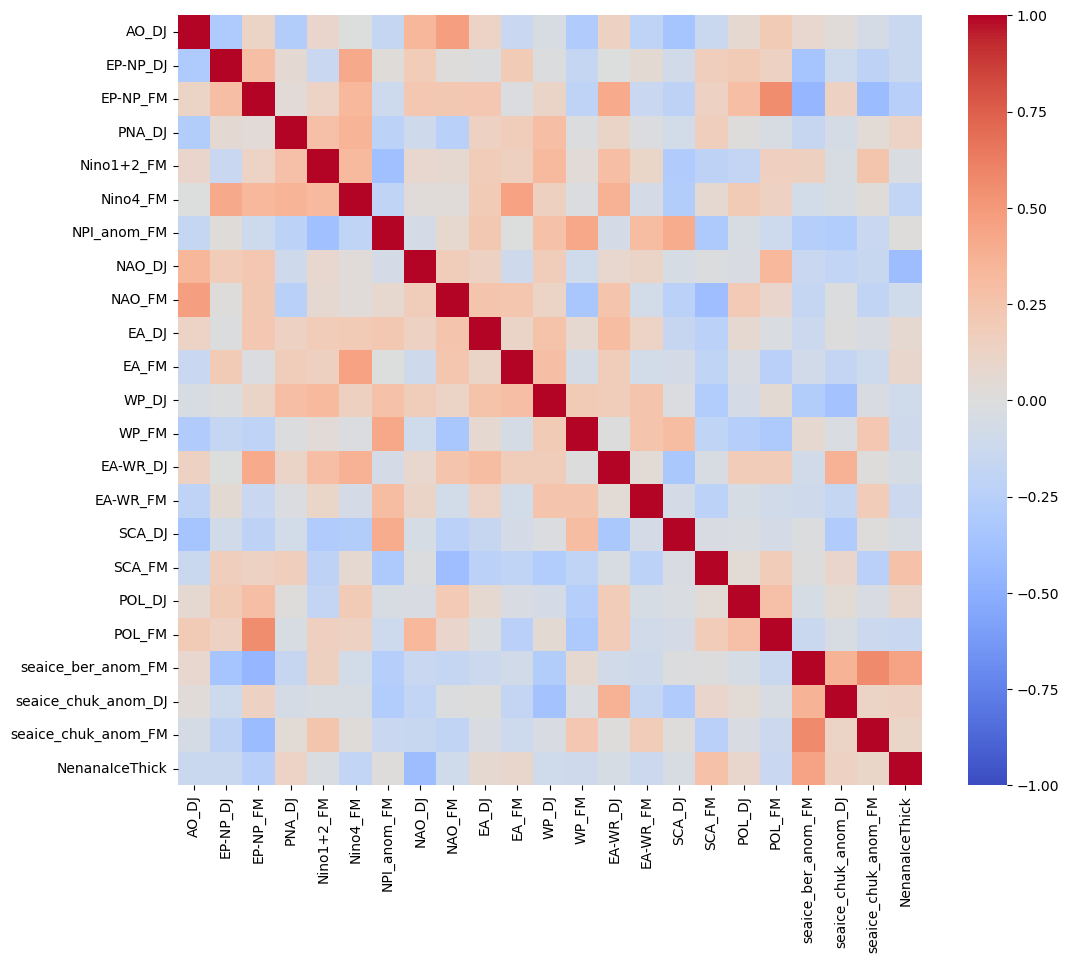

In [ ]:
figure = plt.figure(figsize=(12, 10))
sns.heatmap(X[vif_data.Feature].corr(),cmap='coolwarm', vmin=-1, vmax=1)

Straight CV

In [ ]:
X_new = X[vif_data.Feature]

In [ ]:
saveplots = True
summary = {}
summary['location'] = location
summary['predictors'] = list(X_new.columns)

In [ ]:
X_new

,AO_DJ,EP-NP_DJ,EP-NP_FM,PNA_DJ,Nino1+2_FM,Nino4_FM,NPI_anom_FM,NAO_DJ,NAO_FM,EA_DJ,...,EA-WR_DJ,EA-WR_FM,SCA_DJ,SCA_FM,POL_DJ,POL_FM,seaice_ber_anom_FM,seaice_chuk_anom_DJ,seaice_chuk_anom_FM,NenanaIceThick
1980,-0.385,0.53,0.505,-0.845,-0.215,0.275,-6.805,-0.375,-0.560,-1.185,...,-0.430,-0.860,-0.535,1.045,-0.675,0.235,75710.183,21679.526,-19276.681,39.755556
1981,-0.087,1.02,0.000,0.945,-0.860,-0.170,-6.466,-0.095,-0.525,-0.970,...,-0.755,-0.115,-0.610,-0.140,0.990,-0.330,26487.476,17966.648,-6019.920,39.755556
1982,-1.050,1.11,0.785,-1.085,-1.040,-0.055,5.443,0.005,0.830,-0.785,...,0.160,1.035,-0.525,0.725,-0.035,-0.145,-96388.226,24221.572,-31356.242,39.755556
1983,1.163,-0.31,-0.455,0.660,2.130,0.280,-14.832,0.760,-0.225,0.270,...,0.165,0.220,-1.600,-0.025,-1.035,0.030,49359.743,15481.615,-1402.764,39.755556
1984,0.545,-0.97,-0.215,-0.005,-0.875,-0.785,-6.560,0.665,-0.210,-0.745,...,-1.000,-1.960,1.190,1.385,-0.150,0.740,94515.412,-31582.156,-29958.123,39.755556
1985,-1.180,1.00,-1.540,-0.230,-1.135,-0.860,8.899,-1.135,-0.595,-0.330,...,-0.195,0.280,0.235,0.435,-1.405,-0.120,-89663.552,18533.806,-1291.347,39.755556
1986,-1.258,0.52,0.450,0.840,-0.415,-0.195,-8.771,0.805,-0.095,0.175,...,0.155,0.640,0.325,1.045,-0.020,1.535,-8794.729,7294.795,2074.965,39.755556
1987,-0.544,-0.74,0.120,0.845,1.205,0.485,-4.644,-0.820,-0.765,0.505,...,1.020,0.225,-0.600,0.255,-0.545,0.205,5861.737,12678.787,4041.550,39.755556
1988,-0.135,1.13,0.065,0.265,-0.560,0.295,-2.562,0.580,-0.080,-0.095,...,-0.170,-1.835,-0.630,0.545,0.730,-0.090,28827.164,11798.344,11798.344,39.755556
1989,2.393,-1.81,1.470,-0.620,-0.105,-1.345,6.232,-0.150,1.680,1.060,...,0.605,-0.255,-0.945,-0.880,0.165,0.790,-167318.865,49909.344,-45284.596,42.000000


In [ ]:
# load model 
modeldir = ML_LOC / 'models'
filename = f"{location.replace(' ', '_')}_joblib_model.sav"
best_model = joblib.load(modeldir / filename)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/christine/Projects/2023_Riverice/data/ML_2024_redux/models/Tanana_River_at_Nenana_joblib_model.sav'

... or calculate it 

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=43)
model = GradientBoostingRegressor(random_state=40)
    # define search space
space = {
        # 'min_samples_leaf': list(range(4, 7)),
        'min_samples_leaf': [5],
        # 'max_depth': [ 4],
        'min_samples_split': [5],
        # 'max_depth': [3],
        'n_estimators': [500],  # , 1000, 2000, 5000],
        'learning_rate': np.arange(0.012, 0.12, 0.002),   # 0.006, 0.005], # 0.001, 0.0005, 0.0001],
        'subsample': np.arange(0.2, 0.8, 0.05),
    }
# define search
search = GridSearchCV(model, space, cv=cv_inner, scoring='neg_mean_squared_error', verbose=1, 
            refit=True, n_jobs=6)
# execute search
grid_result = search.fit(X, y)
# get the best performing model fit on the whole training set
best_model = grid_result.best_estimator_
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev}, {param}")

Fitting 5 folds for each of 702 candidates, totalling 3510 fits
-46.34732606443481, 11.451059118913552, {'learning_rate': np.float64(0.012), 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': np.float64(0.2)}
-46.14796209951885, 11.438935498607009, {'learning_rate': np.float64(0.012), 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': np.float64(0.25)}
-36.689858927244764, 13.69598363035707, {'learning_rate': np.float64(0.012), 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': np.float64(0.3)}
-36.41793536812564, 11.819491230782111, {'learning_rate': np.float64(0.012), 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': np.float64(0.35)}
-35.38083657121037, 11.258699370026786, {'learning_rate': np.float64(0.012), 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': np.float64(0.39999999999999997)}
-35.95001180691402, 9.77449159822465, {'lea

In [ ]:
grid_result.cv_results_['mean_test_score'][grid_result.best_index_]

np.float64(-34.150195083868844)

In [ ]:
best_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': np.float64(0.055999999999999994),
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': 40,
 'subsample': np.float64(0.35),
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
summary['modelparams'] = best_model.get_params()
summary['rms_cv'] = np.sqrt(-grid_result.cv_results_['mean_test_score'][grid_result.best_index_])
summary['rms_std_cv'] = np.sqrt(grid_result.cv_results_['std_test_score'][grid_result.best_index_])

The mean absolute error (MAbsE) on train set: 1.2520
The mean absolute error (MAbsE) on test set: 5.3898
The score for this training set is 0.9200
The validation score for this test set is -0.0413
Pearson score on training set: 0.9739
Pearson score on test set: 0.3082



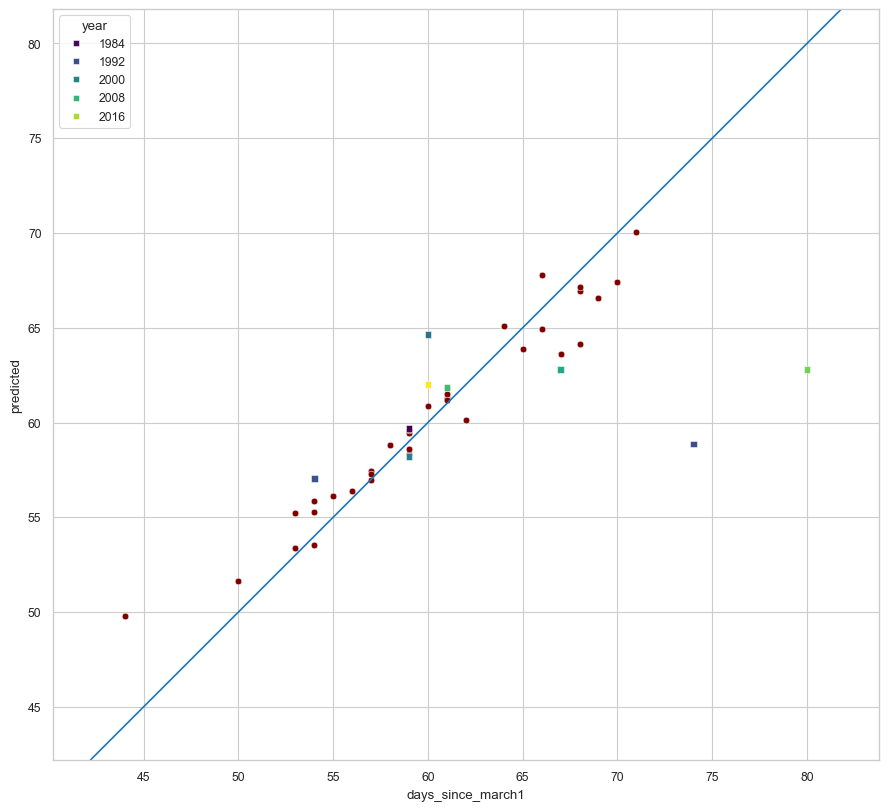

In [ ]:
random_seed = 2024
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.20, random_state=random_seed)

params_gb = {
        'min_samples_leaf': 3,
        'min_samples_split': 3,
        'max_depth': 2,
        # 'n_estimators': [250, 200, 150, 100],
        'n_estimators': 50,
        'learning_rate': 0.08,
        'subsample': 0.65,
    'random_state': random_seed, 
}
model1 = GradientBoostingRegressor(**params_gb)
model2 = RandomForestRegressor(random_state=random_seed)
model2 = best_model
model3 = ExtraTreesRegressor(n_estimators=200)
model3 = RandomForestRegressor(random_state=random_seed)
# define search
model = VotingRegressor(estimators=[('gb', model1), ('rf', model2), ('lr', model3)])
model = model1
# execute search
result = model.fit(X_train, y_train)
# get the best performing model fit on the whole training set
mse = mean_absolute_error(y_train, model.predict(X_train))
print("The mean absolute error (MAbsE) on train set: {:.4f}".format(mse))
mse = mean_absolute_error(y_test, model.predict(X_test))
print("The mean absolute error (MAbsE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True)

sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='maroon', ax=ax)
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, hue='year', marker='s', palette='viridis', ax=ax)
lims = ax.get_xlim()
ax.set_ylim(lims)
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]])
ax.set_aspect('equal')
plt.show(fig)
if saveplots:
    outdir = ML_LOC / "overfitting_tests"
    fn = f"{location.replace(' ', '_')}_overfit.png"
    fig.savefig(outdir / fn, bbox_inches='tight')

The mean absolute error (MAbsE) on train set: 2.1596 days
The mean absolute error (MAbsE) on test set: 5.5080 days
The score for this training set is 0.7452
The validation score for this test set is 0.0240
Pearson score on training set: 0.8927
Pearson score on test set: 0.2442



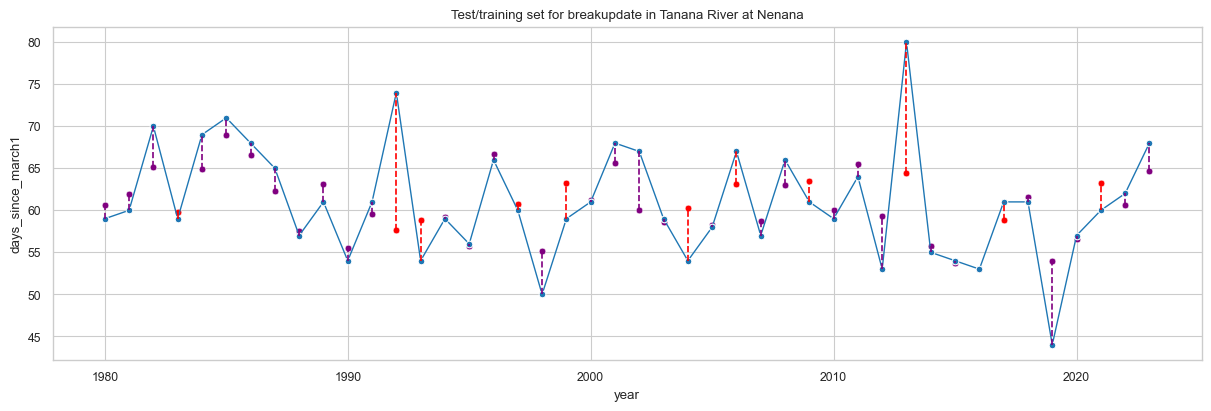

In [ ]:
var = 'days_since_march1'

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=random_seed)
model = best_model
# model = model1

model.fit(X_train, y_train)
mse = mean_absolute_error(y_train, model.predict(X_train))
print("The mean absolute error (MAbsE) on train set: {:.4f} days".format(mse))
mse = mean_absolute_error(y_test, model.predict(X_test))
print("The mean absolute error (MAbsE) on test set: {:.4f} days".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = best_model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', var]
plot_df['predicted_test'] = model.predict(X_test) 
plot_df_train = pd.DataFrame(y_train)
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', var]
plot_df_train['predicted_train'] = model.predict(X_train) 
plot_df = pd.concat([plot_df, plot_df_train]).sort_values(by='year')
plot_df[f'{var}'] = plot_df[f'{var}']


fig, ax = plt.subplots(figsize=(12, 4))

# observed data
sns.lineplot(x='year', y=var, data=plot_df, ax=ax, marker="o", lw=1)
# training data 
# for vertical lines
aux1 = plot_df[['year', f'{var}', 'predicted_train']].dropna()
aux1['min'] = aux1[[f'{var}', 'predicted_train']].min(axis=1)
aux1['max'] = aux1[[f'{var}', 'predicted_train']].max(axis=1)
for _, item in aux1.iterrows():
    plt.vlines(item['year'], item['min'], item['max'], color='purple', linestyles='dashed')
sns.scatterplot(x='year', y='predicted_train', data=aux1, color='purple', ax=ax)

# test data
# for vertical lines
aux1 = plot_df[['year', f'{var}', 'predicted_test']].dropna()
aux1['min'] = aux1[[f'{var}', 'predicted_test']].min(axis=1)
aux1['max'] = aux1[[f'{var}', 'predicted_test']].max(axis=1)
for _, item in aux1.iterrows():
    plt.vlines(item['year'], item['min'], item['max'], color='red', linestyles='dashed')
sns.scatterplot(x='year', y='predicted_test', data=aux1, color='red', ax=ax)
plt.title(f"Test/training set for breakupdate in {location}")

plt.show(fig)

In [ ]:
var = 'days_since_march1'

testsizes = np.arange(0.01, 0.90, 0.01)
test_errors = []
training_errors = []
for testsize in testsizes:
    training_store = []
    for ii in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=testsize, random_state=random_seed+ii)
        model = best_model
        model.fit(X_train, y_train)
        training_store.append(mean_absolute_error(y_test, model.predict(X_test)))
    training_errors.append(mean_absolute_error(y_train, model.predict(X_train)))
    test_errors.append(sum(training_store)/10)



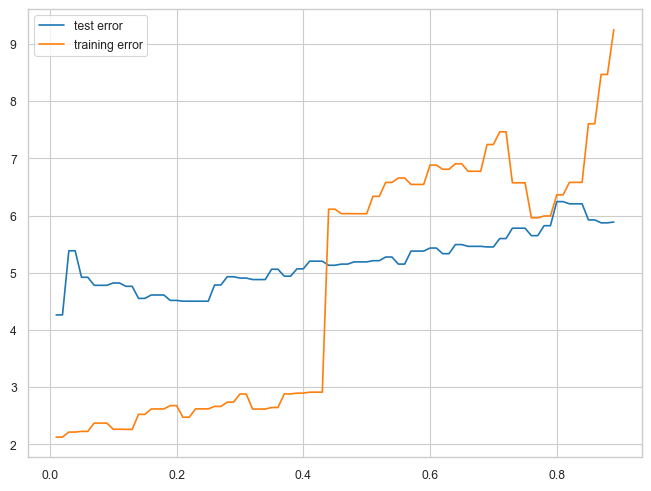

In [ ]:
fig, ax = plt.subplots()

plt.plot(testsizes, test_errors, label='test error')
plt.plot(testsizes, training_errors, label='training error')
plt.legend()

With cross-validation

In [ ]:
cross_val_score(model, X_new, y, cv=0, scoring='neg_mean_absolute_error', n_jobs=-1)

array([ -5.55284961,  -4.62729308,  -2.45078565,  -3.5945344 ,
       -10.61662889,  -3.07523779,  -1.8724309 ,  -5.67327994,
        -3.21196711,  -5.18955122,  -2.90482755,  -5.29710375,
        -4.69358492,  -3.36359544, -13.97054427,  -1.65475139,
        -2.38375361,  -7.56938707,  -3.00326093,  -4.69438597])

In [ ]:
y.std()

np.float64(6.732074310664797)

In [ ]:
model.score(X_train, y_train)

0.8933482755898345

In [ ]:
model.score(X_test, y_test)

-0.3333000974961944

/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_37488/1715048033.py:14: UserWarning: The figure layout has changed to tight
  ax.figure.tight_layout()


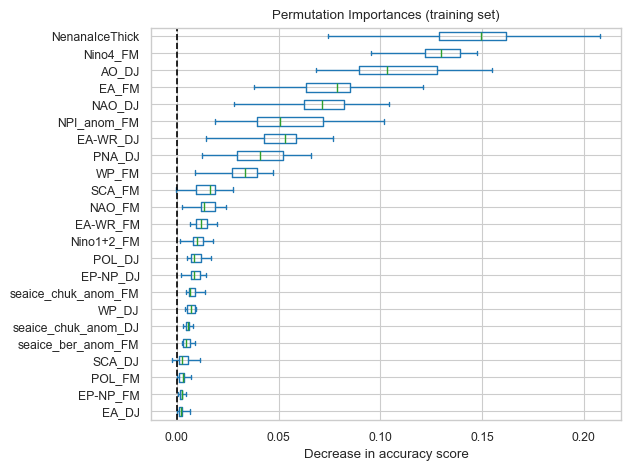

In [ ]:
result = permutation_importance(
    model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (training set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_train.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_37488/1573464195.py:14: UserWarning: The figure layout has changed to tight
  ax.figure.tight_layout()


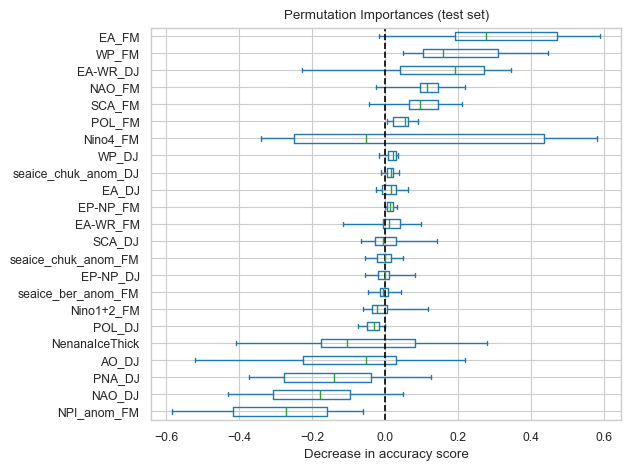

In [ ]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_new.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_permutation_imp_test.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
importances.columns[-12:]

Index(['EA-WR_FM', 'EP-NP_FM', 'EA_DJ', 'seaice_chuk_anom_DJ', 'WP_DJ',
       'Nino4_FM', 'POL_FM', 'SCA_FM', 'NAO_FM', 'EA-WR_DJ', 'WP_FM', 'EA_FM'],
      dtype='object')

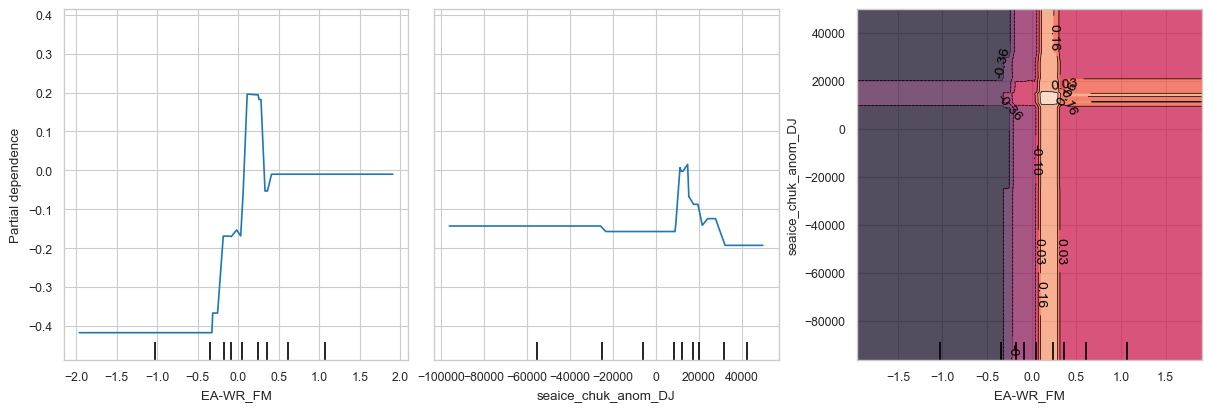

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
sns.set_context('paper')
plt.rcParams['figure.constrained_layout.use'] = True

figure, ax = plt.subplots(figsize=(12, 4))

clf = model.fit(X_train, y_train)
PartialDependenceDisplay.from_estimator(clf, X_new, 
    ['EA-WR_FM', 'seaice_chuk_anom_DJ', ('EA-WR_FM', 'seaice_chuk_anom_DJ')],
    ax=ax)

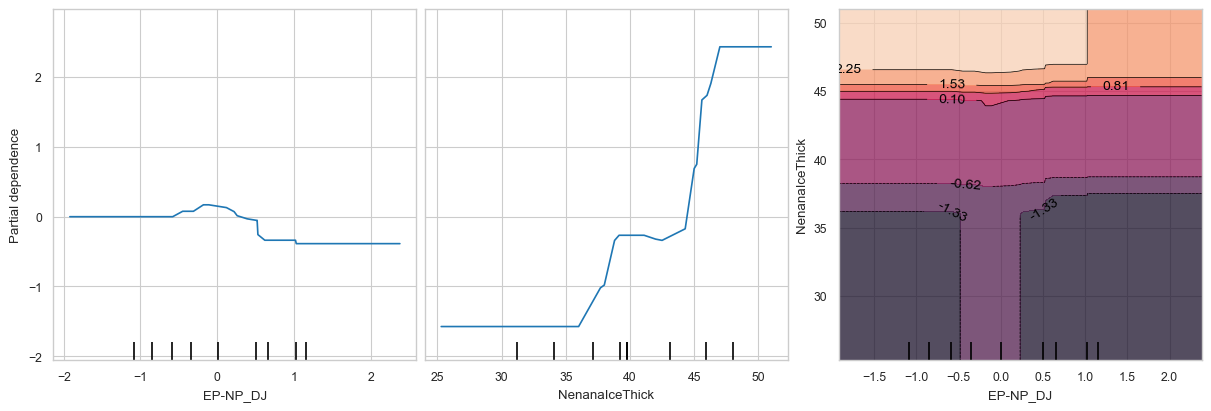

In [ ]:
figure, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(clf, X_new, 
    ['EP-NP_DJ', 'NenanaIceThick', ('EP-NP_DJ', 'NenanaIceThick')],
    ax=ax)

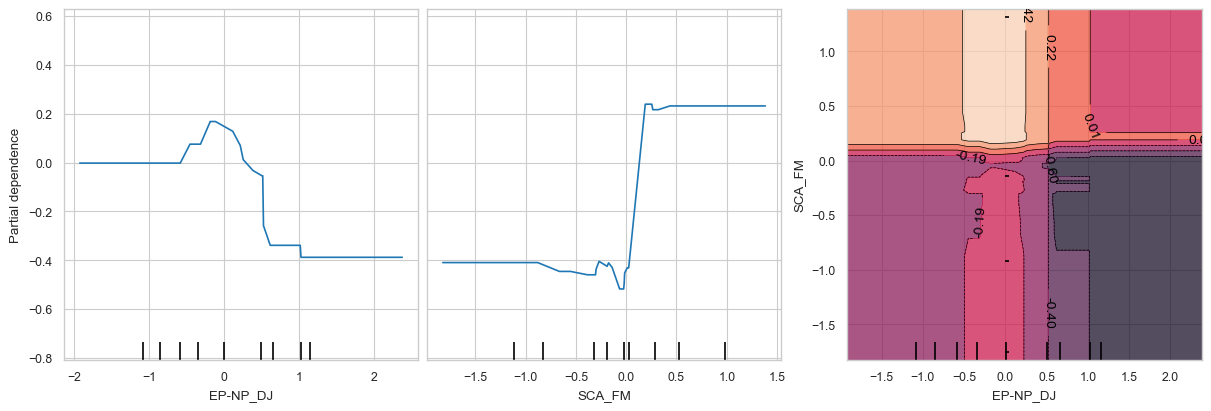

In [ ]:
figure, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(clf, X_new, 
    ['EP-NP_DJ', 'SCA_FM', ('EP-NP_DJ', 'SCA_FM')],
    ax=ax)

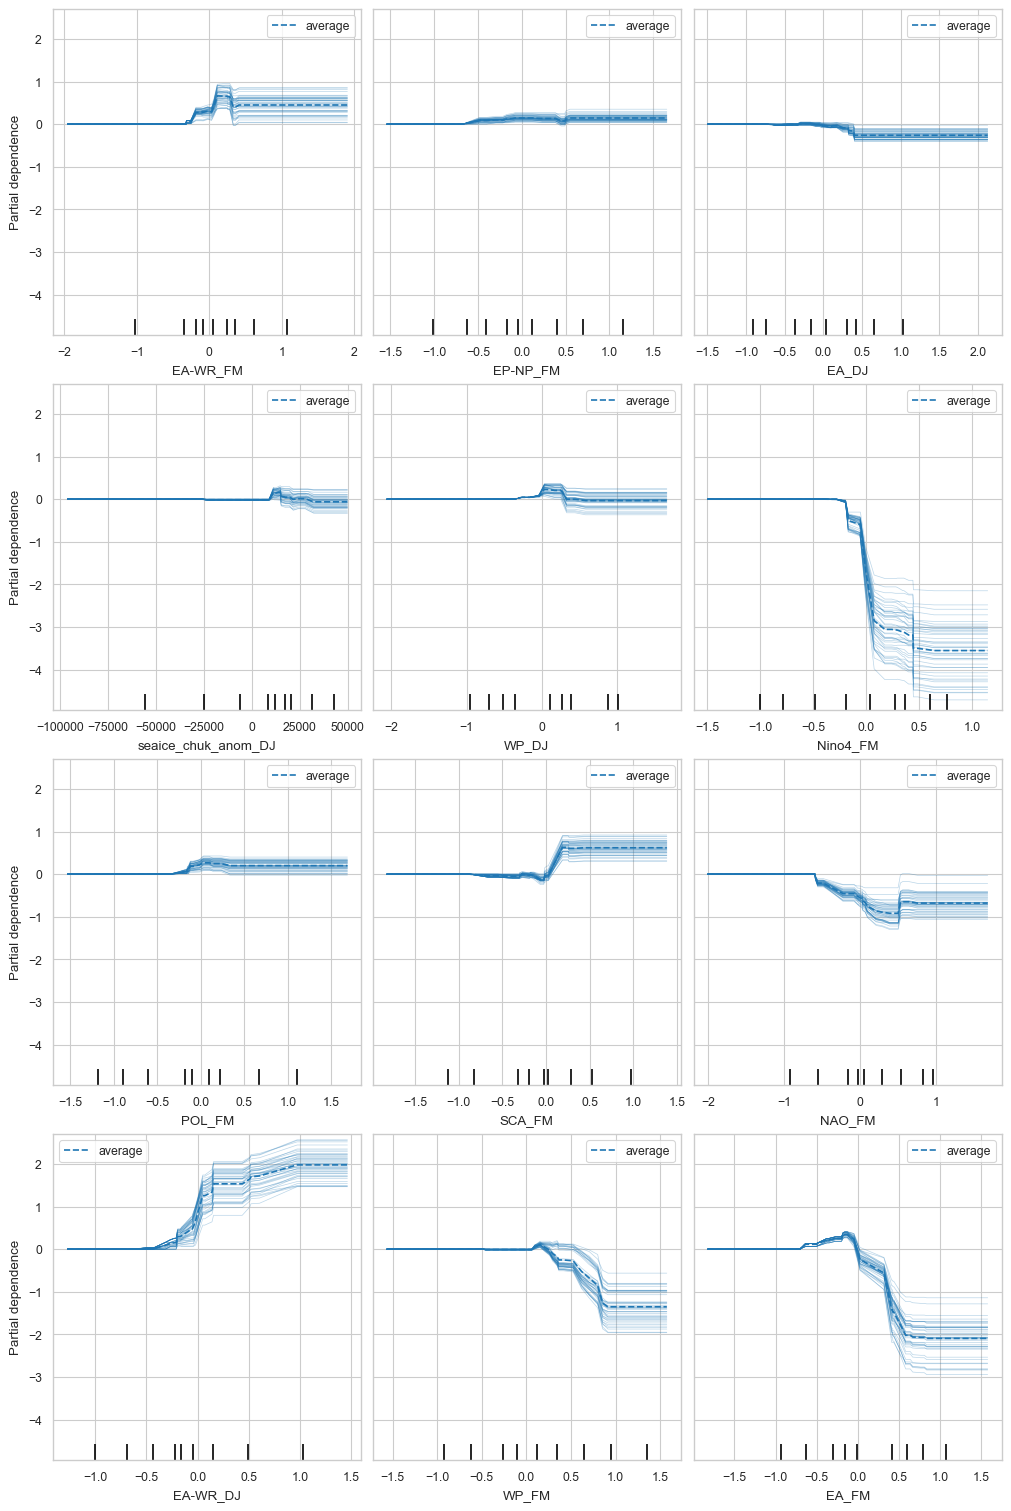

In [ ]:
figure, ax = plt.subplots(figsize=(10, 15))

clf = model.fit(X_train, y_train)
PartialDependenceDisplay.from_estimator(clf, X_new, importances.columns[-12:],
    kind='both', ax=ax, centered=True)

In [ ]:
sns.set_style('whitegrid')

The mean squared error (MSE) on train set: 15.8488
The mean squared error (MSE) on test set: 34.6207
The score for this training set is 0.5698
The validation score for this test set is -0.4961
Pearson score on training set: 0.8310
Pearson score on test set: -0.2908



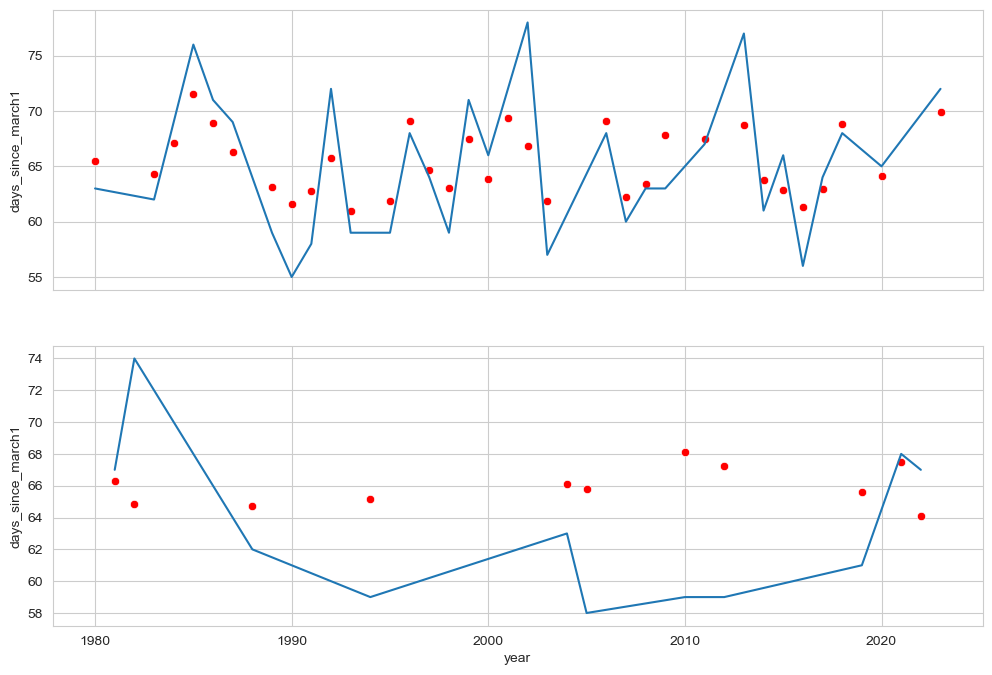

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)
model = best_model

model.fit(X_train, y_train)
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = best_model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='blue', ax=ax)
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, color='red', ax=ax)
# ax.set_box_aspect(1)
plt.show(fig)

In [ ]:
X_test

,AO_FM,EP-NP_FM,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick
1993,0.474,1.165,0.145,0.075,-0.925,0.540,1.685,26.000000
2005,-1.309,0.010,0.875,0.640,-0.505,-0.575,0.145,32.000000
1987,-1.610,0.120,0.310,0.485,-0.375,-0.545,0.205,39.755556
1999,-0.505,-0.925,-1.580,-1.495,-1.825,-0.030,-0.620,46.000000
2000,0.312,-0.475,-1.345,-1.450,-0.135,-0.675,-1.535,37.700000
2002,1.103,0.550,0.260,0.355,1.030,-0.075,-0.350,48.000000
2001,-1.155,-0.450,-0.920,-0.765,0.420,0.025,-0.915,38.800000
2008,0.762,-1.010,-1.285,-1.465,0.315,-0.415,0.095,45.600000
2022,0.924,-0.275,-0.555,-0.530,0.835,-0.775,-1.075,31.250000
2004,-0.605,-0.890,0.430,0.240,0.765,-0.105,-1.165,35.500000


In [ ]:
best_model.fit(X_new, y)
prediction = best_model.predict(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
since_date = dt.datetime.strptime('202403011200', "%Y%m%d%H%M")
preddate = (since_date + dt.timedelta(days=prediction.item())).date().strftime("%Y-%m-%d")

summary['prediction_2024'] = prediction.item()
summary['pred_date_2024'] = preddate

preddate



# ru.dayssince2date(prediction.item())

'2024-05-05'

In [ ]:
summary

{'location': 'Koyukuk River at Bettles',
 'predictors': ['AO_FM',
  'EP-NP_FM',
  'Nino4_DJ',
  'Nino4_FM',
  'EA_FM',
  'POL_DJ',
  'POL_FM',
  'NenanaIceThick'],
 'modelparams': {'alpha': 0.9,
  'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.001,
  'loss': 'squared_error',
  'max_depth': 3,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 2000,
  'n_iter_no_change': None,
  'random_state': 40,
  'subsample': 0.5,
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': 0,
  'warm_start': False},
 'rms_cv': 6.584772157246977,
 'rms_std_cv': 3.5896859626895004,
 'prediction_2024': 65.37169367143437,
 'pred_date_2024': '2024-05-05'}

### Shaply analysis

In [ ]:
import shap

In [ ]:
X_sample = shap.utils.sample(X_new, 50)

In [ ]:
X_test

,AO_FM,EP-NP_FM,Nino4_DJ,Nino4_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick
1993,0.474,1.165,0.145,0.075,-0.925,0.540,1.685,26.000000
2005,-1.309,0.010,0.875,0.640,-0.505,-0.575,0.145,32.000000
1987,-1.610,0.120,0.310,0.485,-0.375,-0.545,0.205,39.755556
1999,-0.505,-0.925,-1.580,-1.495,-1.825,-0.030,-0.620,46.000000
2000,0.312,-0.475,-1.345,-1.450,-0.135,-0.675,-1.535,37.700000
2002,1.103,0.550,0.260,0.355,1.030,-0.075,-0.350,48.000000
2001,-1.155,-0.450,-0.920,-0.765,0.420,0.025,-0.915,38.800000
2008,0.762,-1.010,-1.285,-1.465,0.315,-0.415,0.095,45.600000
2022,0.924,-0.275,-0.555,-0.530,0.835,-0.775,-1.075,31.250000
2004,-0.605,-0.890,0.430,0.240,0.765,-0.105,-1.165,35.500000


In [ ]:
explainer = shap.Explainer(best_model.predict, X_new)
shap_values = explainer(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
shap_values_all = explainer(X_new)
explainer2 = shap.Explainer(best_model.predict, X_test)
shap_values_test = explainer2(X_test)
sample_ind = 20

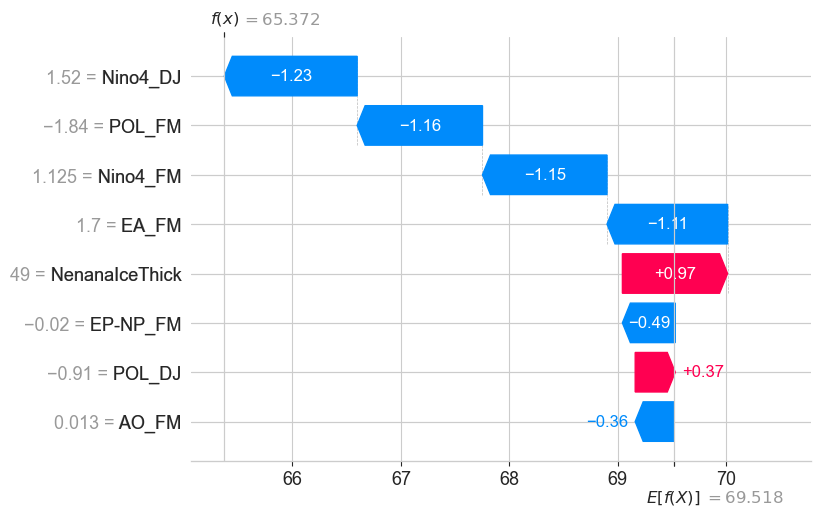

In [ ]:
ax = shap.plots.waterfall(shap_values[0], max_display=20, show=False)
# ax.set_title(f"2024, {location}")
if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_waterfall_2024.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()

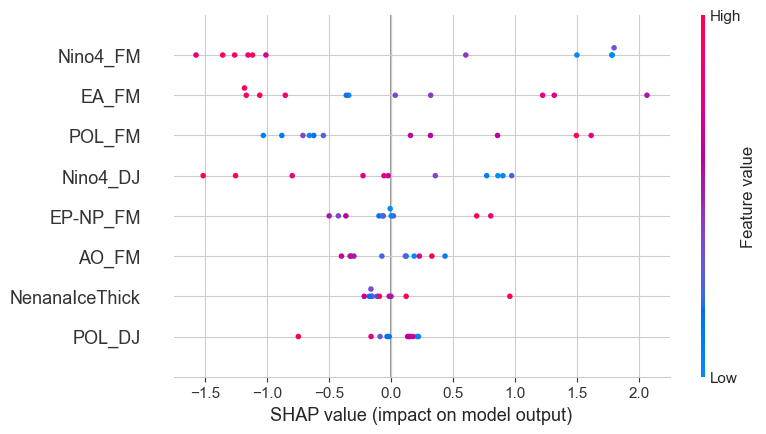

In [ ]:
shap.plots.beeswarm(shap_values_test, max_display=25)

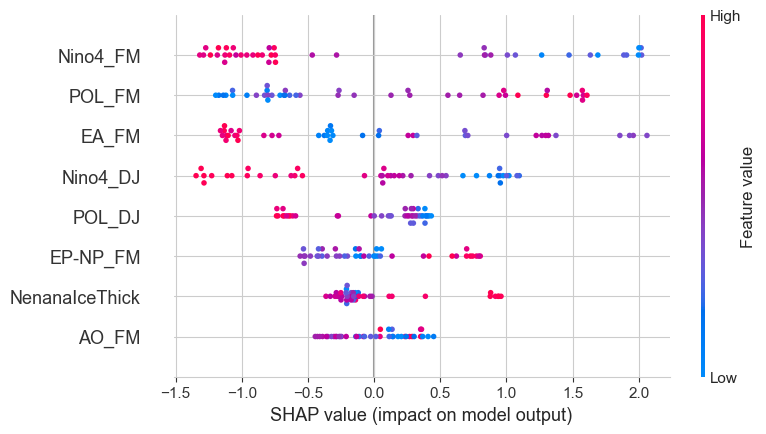

In [ ]:
shap.plots.beeswarm(shap_values_all, max_display=25, show=False)

if saveplots:
    outdir = ML_LOC / "importances"
    fn = f"{location.replace(' ', '_')}_shap_beehive.png"
    plt.savefig(outdir / fn, bbox_inches='tight')
plt.show()


In [ ]:
if saveplots:

    modeldir = ML_LOC / 'models'
    filename = f"{location.replace(' ', '_')}_joblib_model.sav"
    joblib.dump(model, modeldir / filename)
    summarydir =ML_LOC / 'model_eval'
    summaryfn = f"{location.replace(' ', '_')}_modelsummary.json"
    with open(summarydir / summaryfn, 'w' ) as dst: 
        json.dump(summary, dst, indent=2)
